In [ ]:
import kagglehub
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from pathlib import Path

# These libraries are critical and must be kept (they require NumPy/Pandas inputs)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
import warnings

import stats.stat_functions as sf

In [2]:
# Download latest version
# path = kagglehub.dataset_download("ycanario/home-insurance")
# dataset = pl.read_csv(path+'/home_insurance.csv')
# dataset.columns = [x.lower() for x in dataset.columns]
# dataset.write_parquet('data/home_insurance.parquet')

In [3]:
data_dir = Path('data')
date = dt.date.today().strftime('%Y-%m-%d')
target_dir = data_dir/date
target_dir.mkdir(parents=True,exist_ok=True)

In [4]:
dataset = pl.read_parquet('data/home_insurance.parquet')

In [5]:
dataset= dataset.filter(~pl.col("pol_status").is_null(),
               pl.col("pol_status") != 'Unknown'
               )

Data goes from 256136 to 189005
 - 16 Unknown 
 - 67115 Null


In [6]:
# Set a flag for our end goal targets
dataset = dataset.with_columns((pl.col("pol_status") == 'Lapsed').alias('lapsed_flag'))
lapsed = dataset.filter(pl.col('lapsed_flag') == 1)

In [7]:
null_percs = dataset.null_count()/dataset.shape[0]*100
null_percs = null_percs.transpose(include_header=True,
                             column_names = ['null_perc']).filter(pl.col('null_perc') > 0)

lapsed_null_percs = lapsed.null_count()/lapsed.shape[0]*100
lapsed_null_percs = lapsed_null_percs.transpose(include_header=True,
                                    column_names = ['null_perc_lapsed']).filter(pl.col('null_perc_lapsed') > 0)


In [8]:
null_percs.join(lapsed_null_percs, on='column')

column,null_perc,null_perc_lapsed
str,f64,f64
"""quote_date""",58.129679,45.248791
"""p1_pt_emp_status""",99.057168,98.795066
"""clerical""",98.442369,97.879469
"""risk_rated_area_b""",25.470226,17.116534
"""risk_rated_area_c""",4.619455,5.05387
"""campaign_desc""",100.0,100.0
"""payment_frequency""",57.38208,67.824647
"""mta_fap""",70.701833,70.299235
"""mta_aprp""",70.701833,70.299235


Was looking to see if there was anything interesting in the volume of nulls and the only sniff test differences before further analysis is lower number of nulls in risk rated b areas than non and higher number of nulls in payment frequency. 

But none of these seem to have a quick and easy imputation that can't be accounted for in other areas of the dataset. So have as a first pass just removed them.

In [9]:
removal_list = null_percs.get_column('column').to_list()
dataset = dataset.drop(removal_list)

Convert the remaining dates from str to actual dates

In [10]:
date_cols = ['cover_start', 'p1_dob']
date_expresions = [pl.col(c).str.to_date()for c in date_cols]
dataset = dataset.with_columns(date_expresions)

Reviewing a large number of the columns they are bianry flags. So can be re-encoded as 0 - 1 values with 1 representing Y. 

In [11]:
def get_str_cols(df):
    return [col for col, dtype in df.schema.items()
    if dtype == pl.Utf8]

def get_bool_cols(df):
    return [col for col, dtype in df.schema.items()
    if dtype == pl.Boolean]

In [12]:
string_cols = get_str_cols(dataset)

In [13]:
unique_counts = dataset.select([pl.col(c).n_unique() for c in string_cols]).row(0, named=True)

# 4. Filter the string columns to keep only those with exactly 2 unique values
binary_cols = [
    col for col, n_unique in unique_counts.items()
    if n_unique == 2
]

In [14]:
expressions = [
    pl.col(c)
    .replace({"Y": True},default=False)
    .alias(c)
    for c in binary_cols
]

In [15]:
dataset_encoded = dataset.with_columns(expressions)
display(dataset_encoded)

cover_start,claim3years,p1_emp_status,bus_use,ad_buildings,sum_insured_buildings,ncd_granted_years_b,ad_contents,sum_insured_contents,ncd_granted_years_c,contents_cover,buildings_cover,spec_sum_insured,spec_item_prem,unspec_hrp_prem,p1_dob,p1_mar_status,p1_policy_refused,p1_sex,appr_alarm,appr_locks,bedrooms,roof_construction,wall_construction,flooding,listed,max_days_unocc,neigh_watch,occ_status,ownership_type,paying_guests,prop_type,safe_installed,sec_disc_req,subsidence,yearbuilt,payment_method,legal_addon_pre_ren,legal_addon_post_ren,home_em_addon_pre_ren,home_em_addon_post_ren,garden_addon_pre_ren,garden_addon_post_ren,keycare_addon_pre_ren,keycare_addon_post_ren,hp1_addon_pre_ren,hp1_addon_post_ren,hp2_addon_pre_ren,hp2_addon_post_ren,hp3_addon_pre_ren,hp3_addon_post_ren,mta_flag,last_ann_prem_gross,pol_status,i,police,lapsed_flag
date,bool,str,bool,bool,i64,i64,bool,i64,i64,bool,bool,i64,f64,f64,date,str,bool,str,bool,bool,i64,i64,i64,bool,i64,i64,bool,str,i64,i64,i64,bool,bool,bool,i64,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,str,i64,str,bool
2007-11-22,false,"""R""",false,true,1000000,7,true,50000,7,true,true,7500,44.42,12.45,1939-06-15,"""O""",false,"""M""",false,true,3,11,15,true,3,0,false,"""PH""",8,0,10,true,true,false,1960,"""PureDD""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,274.81,"""Lapsed""",1,"""P000001""",true
2008-01-01,false,"""E""",true,true,1000000,6,true,50000,7,true,true,0,0.0,24.6,1970-05-20,"""M""",false,"""M""",false,false,3,11,15,true,3,0,false,"""PH""",3,0,2,false,false,false,1960,"""PureDD""",true,true,false,false,false,false,false,false,false,false,false,false,false,false,true,308.83,"""Live""",2,"""P000002""",false
2007-11-23,false,"""E""",false,false,0,0,true,50000,7,false,true,0,0.0,0.0,1947-06-10,"""S""",false,"""M""",true,true,2,11,15,true,3,0,true,"""PH""",8,0,9,false,true,false,1946,"""PureDD""",true,true,false,false,false,false,false,false,false,false,false,false,false,false,true,52.65,"""Live""",3,"""P000003""",false
2007-12-12,false,"""R""",false,false,0,0,true,50000,7,false,true,0,0.0,0.0,1925-12-16,"""W""",false,"""F""",false,true,2,11,15,true,3,0,false,"""PH""",18,0,19,false,true,false,1870,"""NonDD""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,54.23,"""Live""",4,"""P000004""",false
2007-12-15,false,"""R""",false,true,1000000,7,true,50000,7,true,true,0,0.0,19.82,1936-02-11,"""M""",false,"""M""",true,true,3,11,15,true,3,0,false,"""PH""",8,0,1,false,true,false,1960,"""DD-Other""",true,true,false,false,true,true,false,false,false,false,false,false,false,false,false,244.58,"""Live""",5,"""P000005""",false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2005-02-22,true,"""R""",false,true,1000000,2,true,50000,2,true,true,0,0.0,19.06,1937-02-15,"""O""",false,"""F""",false,false,3,11,15,true,3,0,false,"""PH""",8,0,2,false,false,false,1980,"""PureDD""",true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,235.08,"""Lapsed""",256132,"""P256132""",true
2000-12-01,false,"""R""",false,true,1000000,5,true,50000,5,true,true,0,0.0,26.79,1928-04-24,"""M""",false,"""M""",false,true,3,11,15,true,3,0,false,"""PH""",8,0,1,false,true,false,1980,"""NonDD""",true,true,false,false,false,false,false,false,false,false,false,false,false,false,true,194.02,"""Live""",256133,"""P256133""",false
2006-01-18,false,"""R""",false,true,1000000,5,true,50000,5,true,true,0,0.0,0.0,1945-05-06,"""O""",false,"""M""",true,true,3,11,15,true,3,0,false,"""PH""",8,0,19,false,true,false,1900,"""PureDD""",true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,287.3,"""Live""",256134,"""P256134""",false


In [16]:
# List the columns that might cause a duplicate error
new_sum_cols = ["total_add_ons_pre_ren", "total_add_ons_post_ren"]

# Drop them if they exist
dataset_encoded = dataset_encoded.drop(new_sum_cols, strict=False)
pre_renual_add_ons = [x for x in dataset_encoded.columns if x.endswith('_pre_ren')]
post_renual_add_ons = [x for x in dataset_encoded.columns if x.endswith('_post_ren')]
# Generate columns needed for insight 
dataset_encoded = dataset_encoded.with_columns(
    (pl.col("cover_start").dt.year() - pl.col("p1_dob").dt.year()).alias("p1_age"),
    (pl.col("cover_start").dt.strftime("%b")).alias("cover_start_month"),
    (pl.col("cover_start").dt.year() - pl.col("yearbuilt")).alias("house_age"),
    (pl.col("sum_insured_buildings") + pl.col("sum_insured_contents")).alias("total_sum_insured"),
    ((pl.col("ncd_granted_years_b") + pl.col("ncd_granted_years_c"))/2).alias("avg_ncd_years"),
    (pl.sum_horizontal(pre_renual_add_ons)).alias(new_sum_cols[0]),
    (pl.sum_horizontal(post_renual_add_ons)).alias(new_sum_cols[1]),
    (pl.when(pl.col("p1_emp_status").is_in(["R", "E"]))
      .then(pl.col("p1_emp_status")).otherwise(pl.lit('O')).alias("p1_emp_status_simple"))
).with_columns((pl.col('total_sum_insured')/(pl.col('avg_ncd_years')+1)).alias('insured_per_ncd_year'))

dataset_encoded

cover_start,claim3years,p1_emp_status,bus_use,ad_buildings,sum_insured_buildings,ncd_granted_years_b,ad_contents,sum_insured_contents,ncd_granted_years_c,contents_cover,buildings_cover,spec_sum_insured,spec_item_prem,unspec_hrp_prem,p1_dob,p1_mar_status,p1_policy_refused,p1_sex,appr_alarm,appr_locks,bedrooms,roof_construction,wall_construction,flooding,listed,max_days_unocc,neigh_watch,occ_status,ownership_type,paying_guests,prop_type,safe_installed,sec_disc_req,subsidence,yearbuilt,payment_method,legal_addon_pre_ren,legal_addon_post_ren,home_em_addon_pre_ren,home_em_addon_post_ren,garden_addon_pre_ren,garden_addon_post_ren,keycare_addon_pre_ren,keycare_addon_post_ren,hp1_addon_pre_ren,hp1_addon_post_ren,hp2_addon_pre_ren,hp2_addon_post_ren,hp3_addon_pre_ren,hp3_addon_post_ren,mta_flag,last_ann_prem_gross,pol_status,i,police,lapsed_flag,p1_age,cover_start_month,house_age,total_sum_insured,avg_ncd_years,total_add_ons_pre_ren,total_add_ons_post_ren,p1_emp_status_simple,insured_per_ncd_year
date,bool,str,bool,bool,i64,i64,bool,i64,i64,bool,bool,i64,f64,f64,date,str,bool,str,bool,bool,i64,i64,i64,bool,i64,i64,bool,str,i64,i64,i64,bool,bool,bool,i64,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,str,i64,str,bool,i32,str,i64,i64,f64,u32,u32,str,f64
2007-11-22,false,"""R""",false,true,1000000,7,true,50000,7,true,true,7500,44.42,12.45,1939-06-15,"""O""",false,"""M""",false,true,3,11,15,true,3,0,false,"""PH""",8,0,10,true,true,false,1960,"""PureDD""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,274.81,"""Lapsed""",1,"""P000001""",true,68,"""Nov""",47,1050000,7.0,0,0,"""R""",131250.0
2008-01-01,false,"""E""",true,true,1000000,6,true,50000,7,true,true,0,0.0,24.6,1970-05-20,"""M""",false,"""M""",false,false,3,11,15,true,3,0,false,"""PH""",3,0,2,false,false,false,1960,"""PureDD""",true,true,false,false,false,false,false,false,false,false,false,false,false,false,true,308.83,"""Live""",2,"""P000002""",false,38,"""Jan""",48,1050000,6.5,1,1,"""E""",140000.0
2007-11-23,false,"""E""",false,false,0,0,true,50000,7,false,true,0,0.0,0.0,1947-06-10,"""S""",false,"""M""",true,true,2,11,15,true,3,0,true,"""PH""",8,0,9,false,true,false,1946,"""PureDD""",true,true,false,false,false,false,false,false,false,false,false,false,false,false,true,52.65,"""Live""",3,"""P000003""",false,60,"""Nov""",61,50000,3.5,1,1,"""E""",11111.111111
2007-12-12,false,"""R""",false,false,0,0,true,50000,7,false,true,0,0.0,0.0,1925-12-16,"""W""",false,"""F""",false,true,2,11,15,true,3,0,false,"""PH""",18,0,19,false,true,false,1870,"""NonDD""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,54.23,"""Live""",4,"""P000004""",false,82,"""Dec""",137,50000,3.5,0,0,"""R""",11111.111111
2007-12-15,false,"""R""",false,true,1000000,7,true,50000,7,true,true,0,0.0,19.82,1936-02-11,"""M""",false,"""M""",true,true,3,11,15,true,3,0,false,"""PH""",8,0,1,false,true,false,1960,"""DD-Other""",true,true,false,false,true,true,false,false,false,false,false,false,false,false,false,244.58,"""Live""",5,"""P000005""",false,71,"""Dec""",47,1050000,7.0,2,2,"""R""",131250.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2005-02-22,true,"""R""",false,true,1000000,2,true,50000,2,true,true,0,0.0,19.06,1937-02-15,"""O""",false,"""F""",false,false,3,11,15,true,3,0,false,"""PH""",8,0,2,false,false,false,1980,"""PureDD""",true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,235.08,"""Lapsed""",256132,"""P256132""",true,68,"""Feb""",25,1050000,2.0,1,0,"""R""",350000.0
2000-12-01,false,"""R""",false,true,1000000,5,true,50000,5,true,true,0,0.0,26.79,1928-04-24,"""M""",false,"""M""",false,true,3,11,15,true,3,0,false,"""PH""",8,0,1,false,true,false,1980,"""NonDD""",true,true,false,false,false,false,false,false,false,false,false,false,false,false,true,194.02,"""Live""",256133,"""P2

## Data Comparison bettwen target variables

Before performing the statistical tests that will help us determine what variables we should include with expectation of significant difference between the lapsed and non lapsed buckets. 

For modeling I have for ease assumed we have a binary calssification problem. However this is hiding the fact that there is a 3rd group of canceled.

In [17]:
def plot_distribution_by_lapsed_status(df, column_name, target_name="pol_status"):
    graph_data = df.select([column_name, target_name])

    plt.figure(figsize=(10,6))
    sns.histplot(data=graph_data.to_pandas(), x=column_name, hue=target_name, multiple="stack", bins=30)
    plt.title(f"Distribution of {column_name} by Lapsed Status")
    plt.xlabel(column_name)
    plt.ylabel(f"Count of {target_name}")
    plt.show()


    # violin plot of age
    plt.figure(figsize=(10,6))
    sns.violinplot(data=graph_data.to_pandas(), x=target_name, y=column_name)
    plt.title(f"Violin Plot of {column_name} by {target_name}")
    plt.xlabel(target_name)
    plt.ylabel(column_name)
    plt.show()

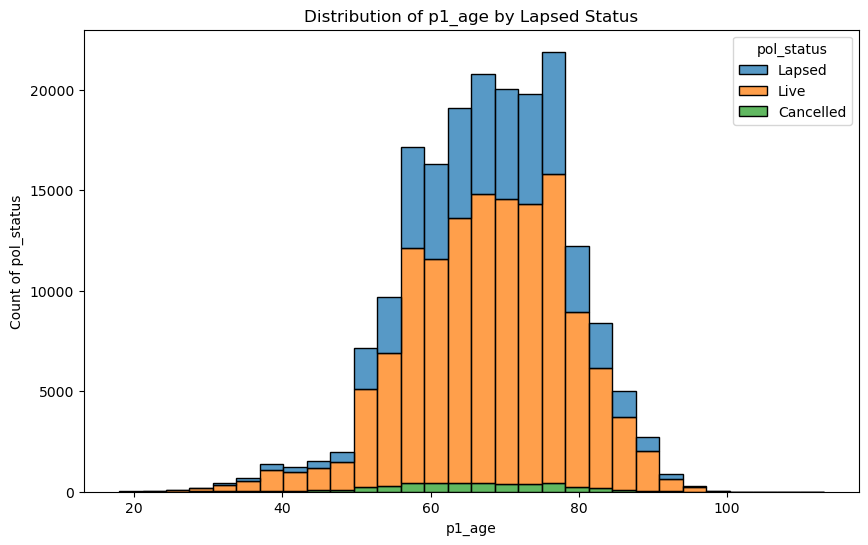

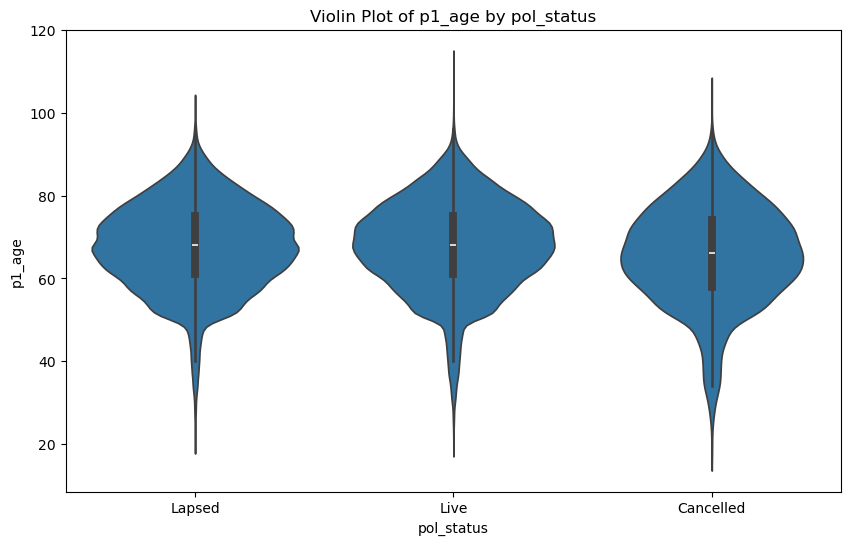

In [ ]:
# break down of age
plot_distribution_by_lapsed_status(dataset_encoded, "p1_age")

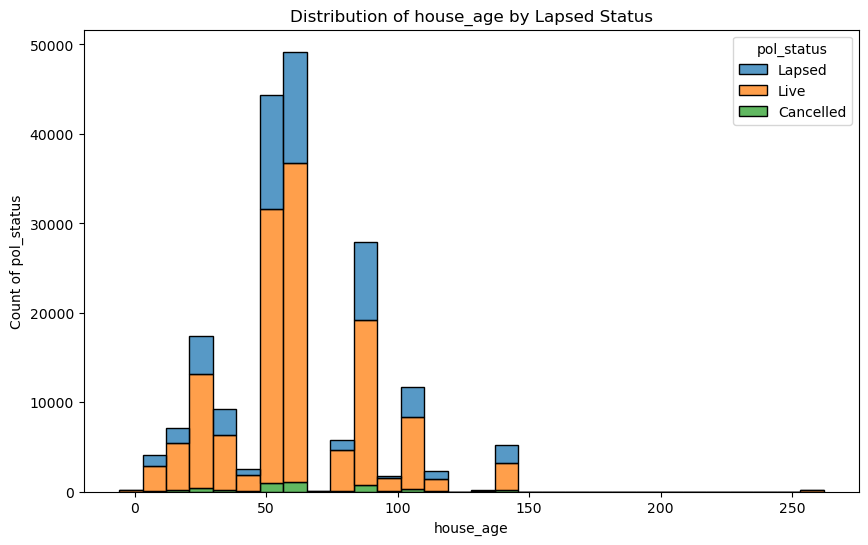

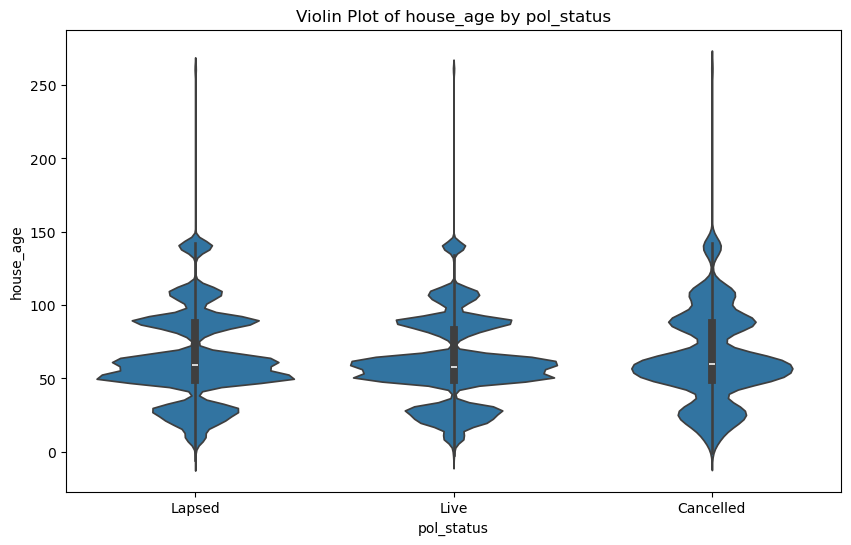

In [19]:
# break down of age of house
plot_distribution_by_lapsed_status(dataset_encoded, "house_age")

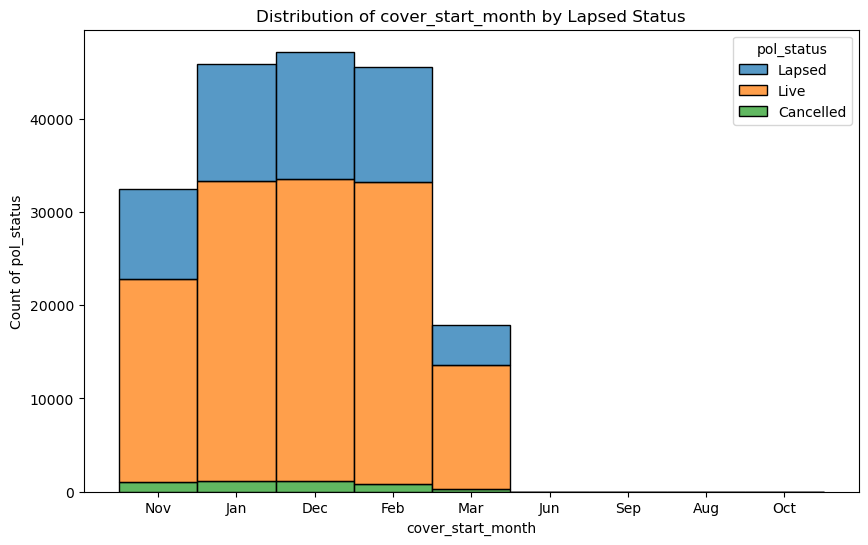

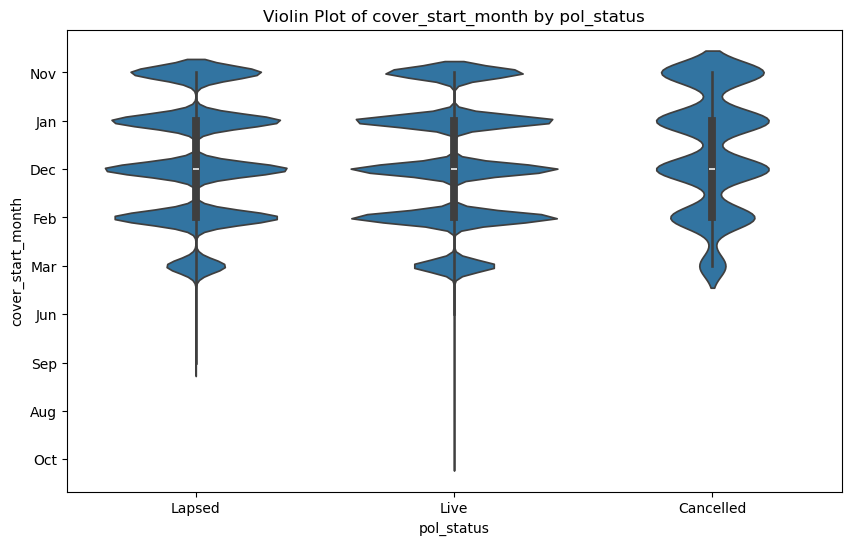

In [20]:
# see breakdowwn by month of coverage start
plot_distribution_by_lapsed_status(dataset_encoded, "cover_start_month")

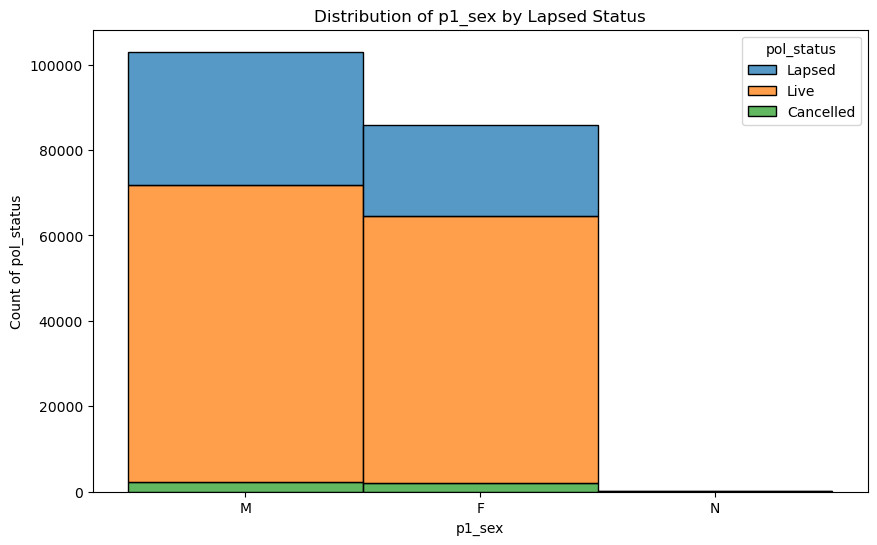

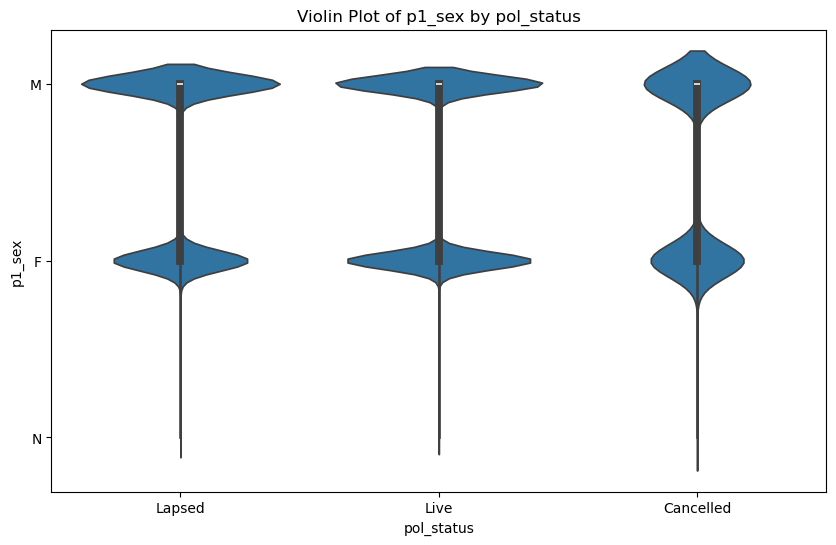

In [21]:
# seem breakdown by gender
plot_distribution_by_lapsed_status(dataset_encoded, "p1_sex")

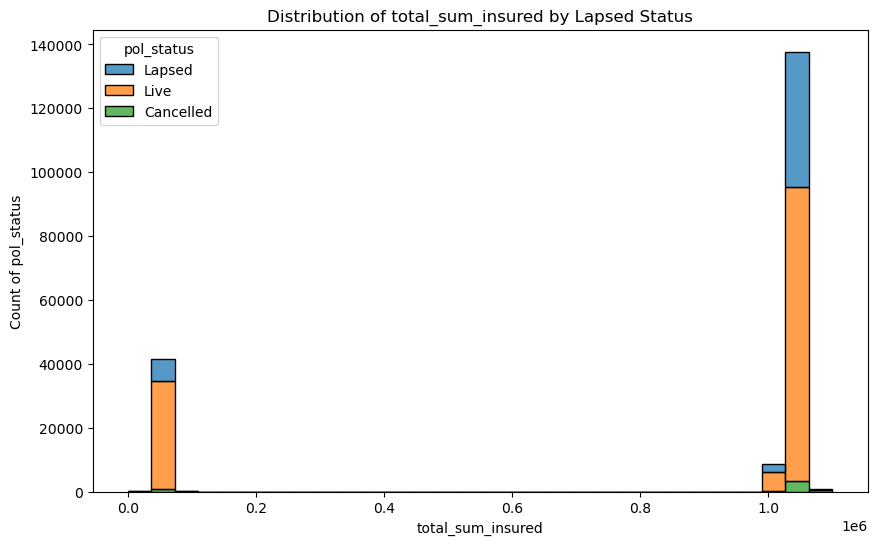

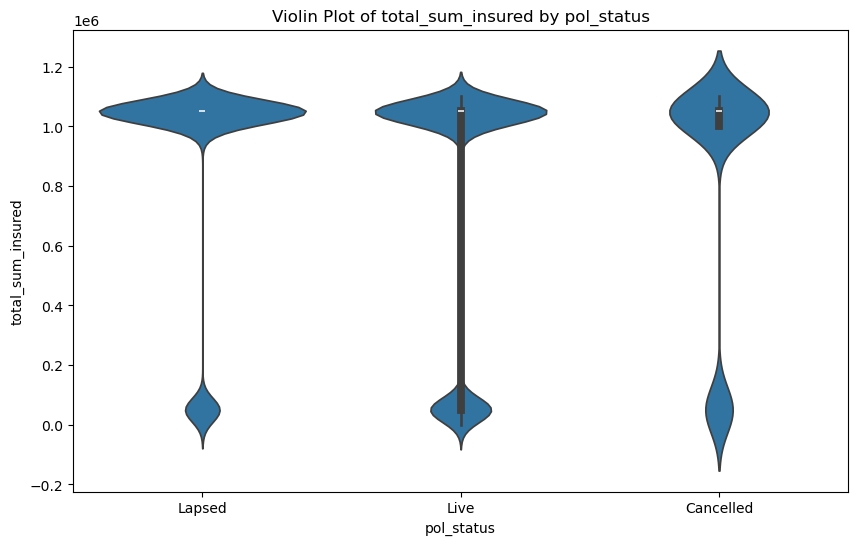

In [22]:
# breakdown by value
plot_distribution_by_lapsed_status(dataset_encoded, "total_sum_insured")

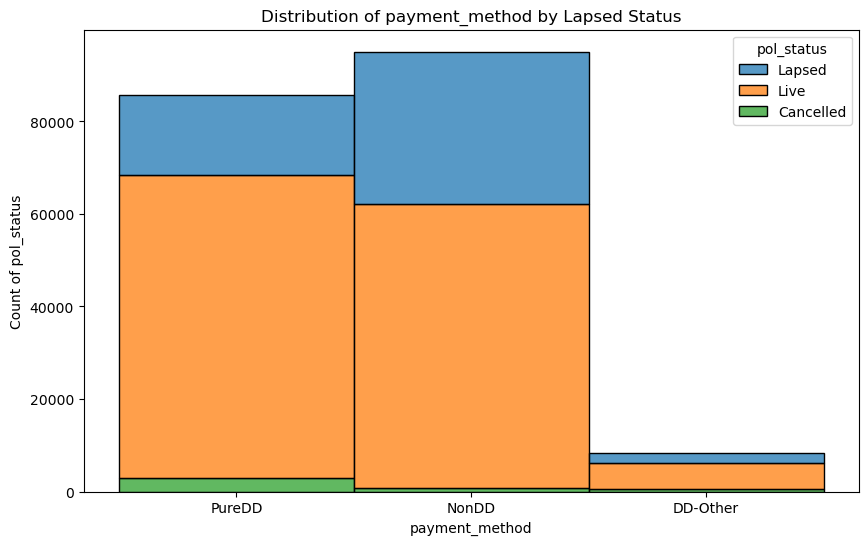

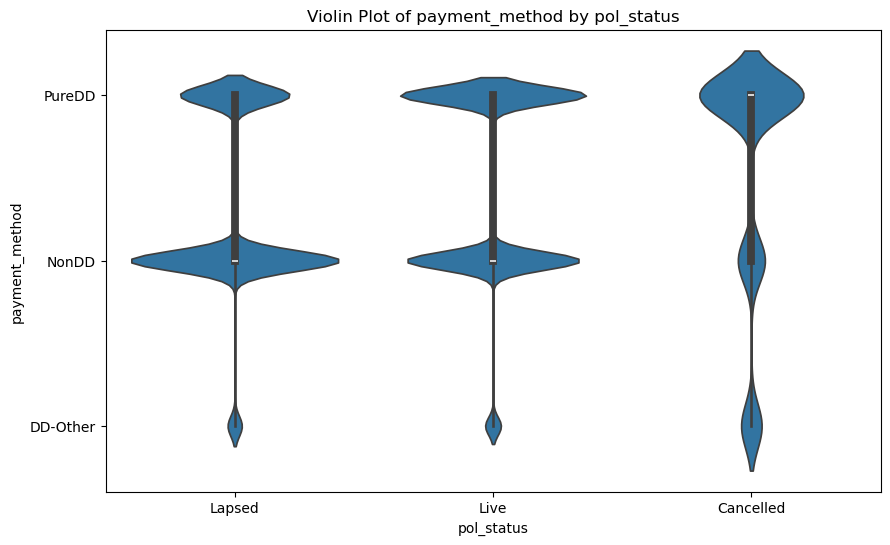

In [23]:
# payment_method
plot_distribution_by_lapsed_status(dataset_encoded, "payment_method")

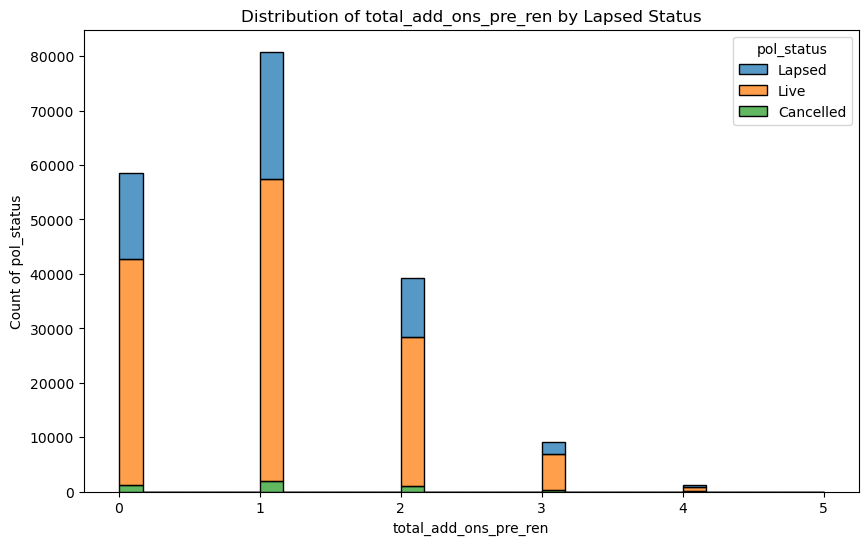

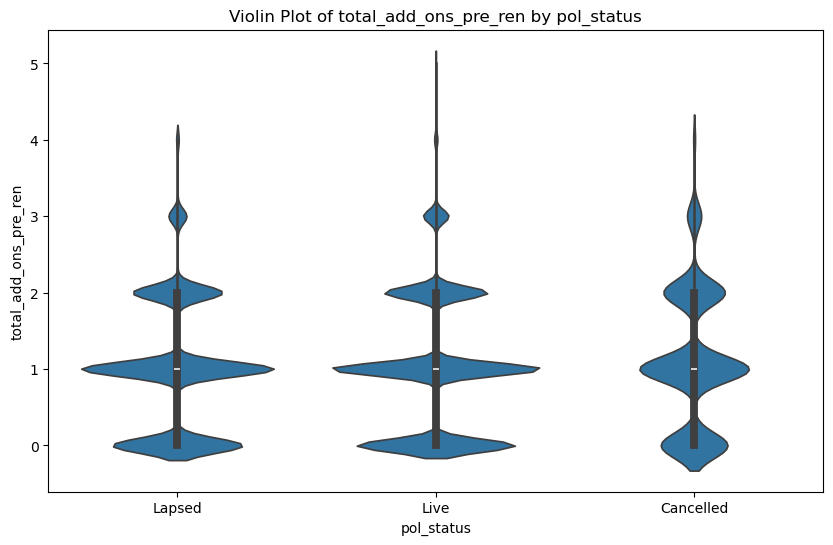

In [24]:
# total add ons pre ren 
plot_distribution_by_lapsed_status(dataset_encoded, "total_add_ons_pre_ren")

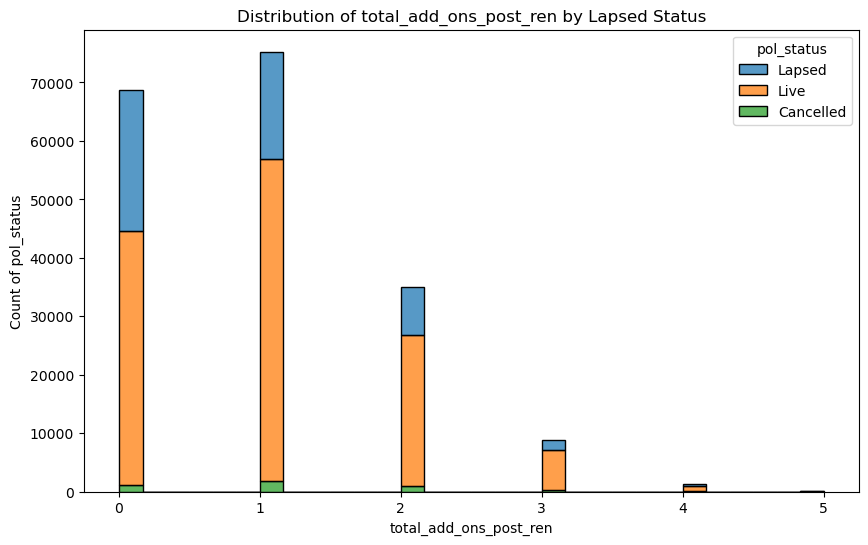

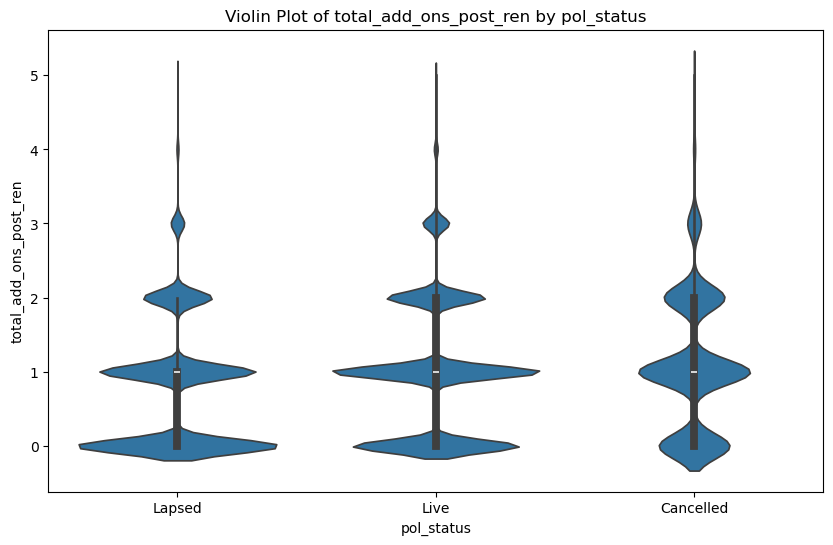

In [25]:
# total add ons post ren 
plot_distribution_by_lapsed_status(dataset_encoded, "total_add_ons_post_ren")

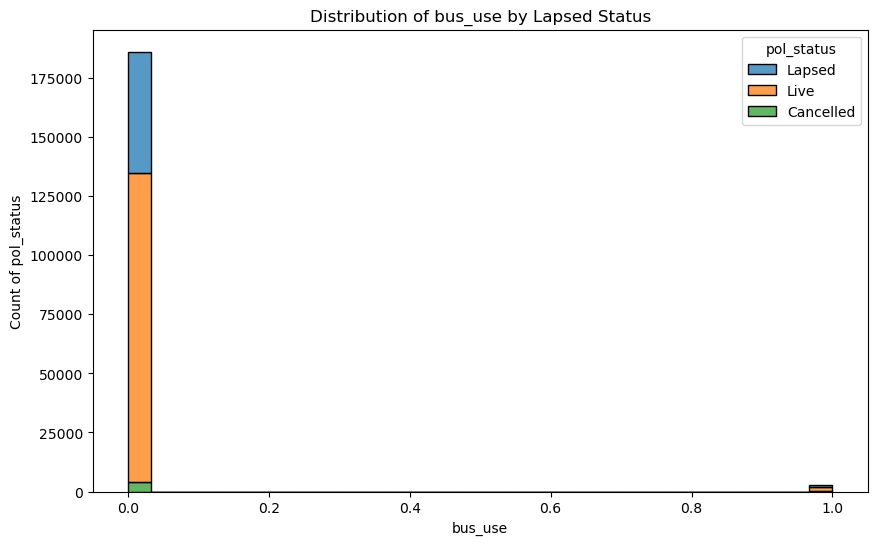

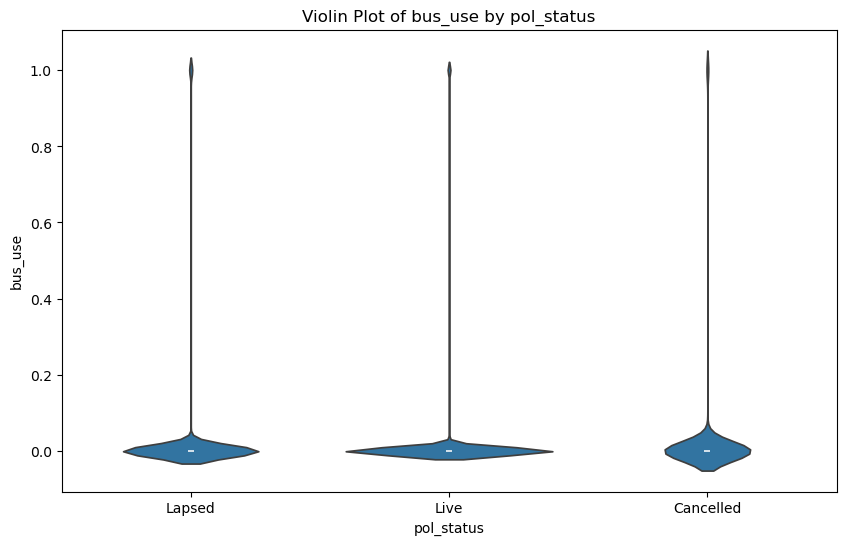

In [26]:
# Buisness Use vs Private Use
plot_distribution_by_lapsed_status(dataset_encoded, "bus_use")

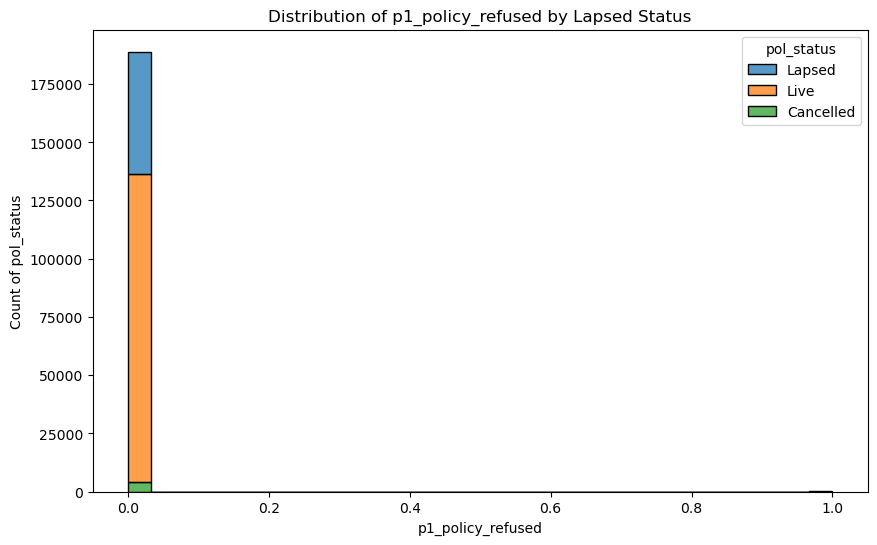

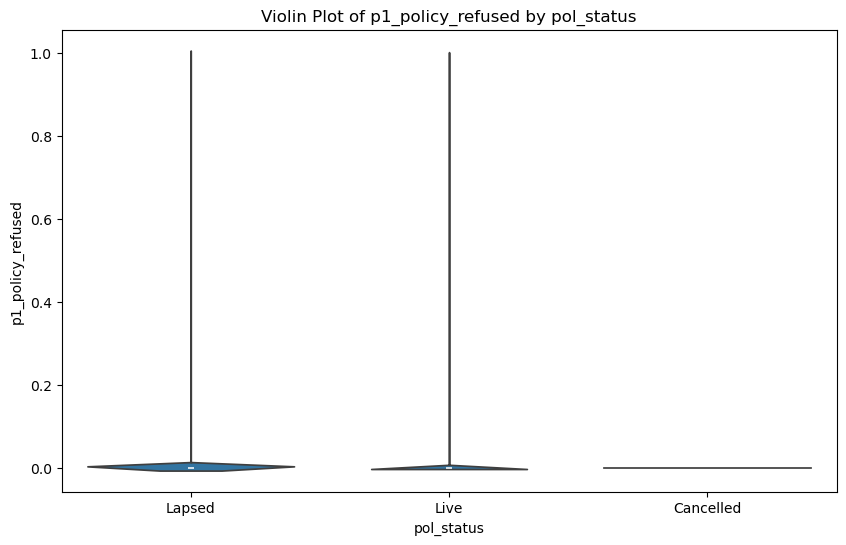

In [27]:
# Policy denial history
plot_distribution_by_lapsed_status(dataset_encoded, "p1_policy_refused")

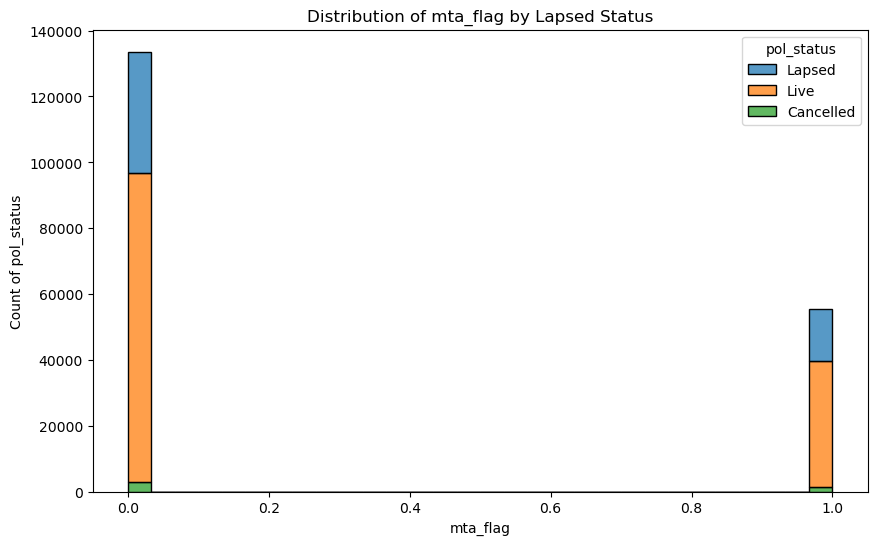

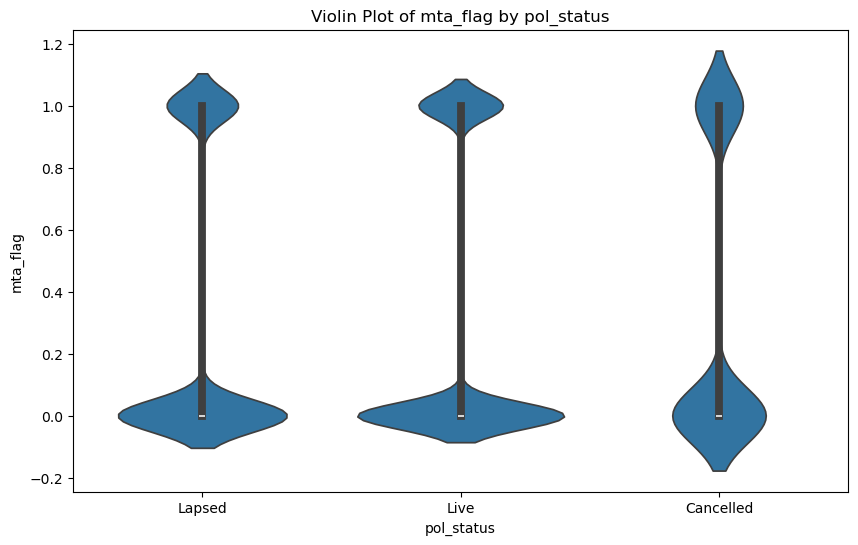

In [28]:
# mid term adjustments
plot_distribution_by_lapsed_status(dataset_encoded, "mta_flag")

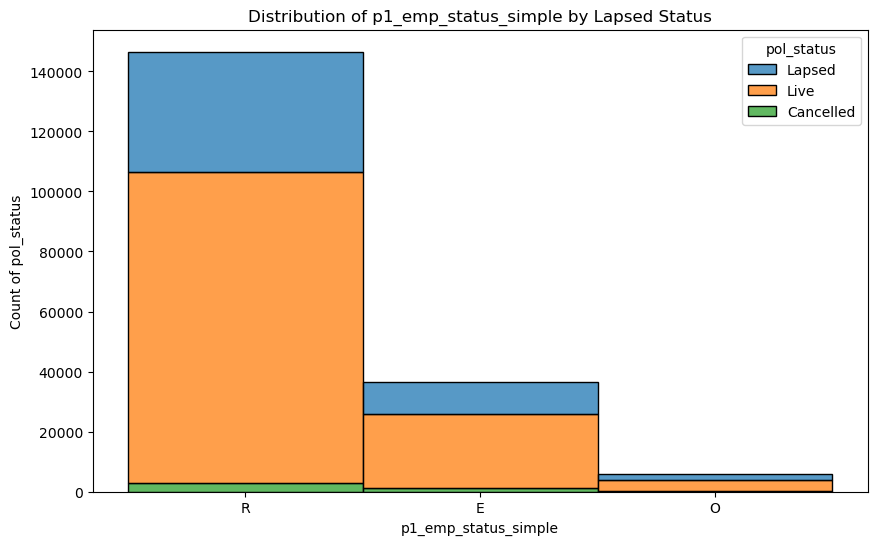

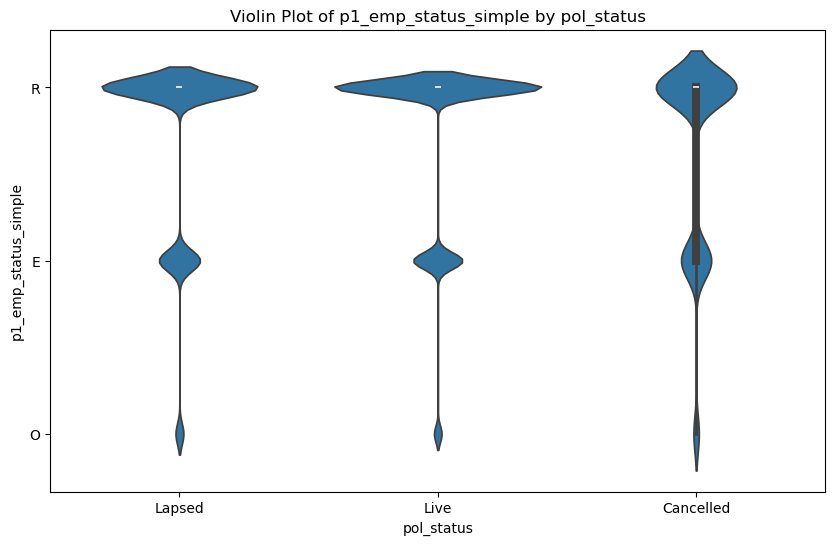

In [29]:
# wall_construction
plot_distribution_by_lapsed_status(dataset_encoded, "p1_emp_status_simple")

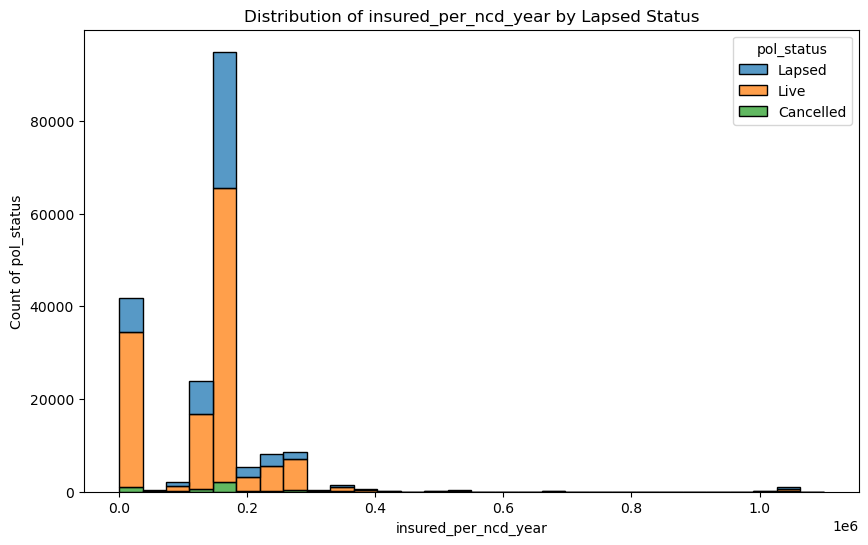

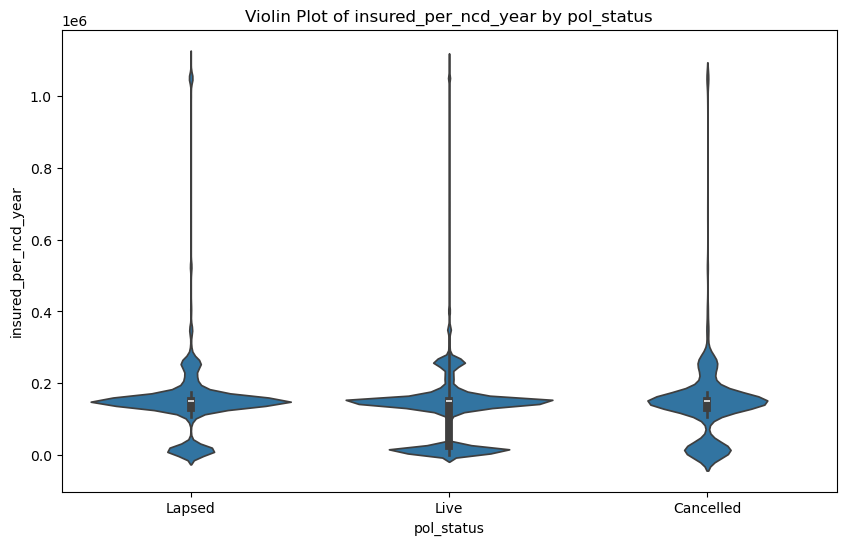

In [30]:
# avg_ncd_years
plot_distribution_by_lapsed_status(dataset_encoded, "insured_per_ncd_year")

The prior encoding should allow us to perform numeric based stats tests on a larger number of the columns than before when comparing against the target group. Below are those numeric tests.

In [31]:
dataset = dataset.drop('pol_status') # dropping as its no longer needed and can cause issues if not dropped

## Stat Tests

In [32]:
dataset_encoded = dataset_encoded.drop(["ncd_granted_years_b", "total_sum_insured", 'pol_status'])

In [33]:
str_cols = get_str_cols(dataset_encoded)[:-2] # removes target and old indexes
bool_cols = get_bool_cols(dataset_encoded)[:-1] # removes target
potential_cat_vars = []

cols = str_cols + bool_cols
for col in cols:
    results = sf.chi_square_test(df=dataset_encoded,
                    categorical_col=col,
                    target_col='lapsed_flag'
                    )
    if (results['significant'] == True):
        display(results)
        potential_cat_vars += [results['variable']]

{'variable': 'p1_emp_status',
 'test': 'Chi-Square',
 'statistic': np.float64(189.3353314371265),
 'p_value': np.float64(2.688396132017199e-35),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (11, 4)
 ┌───────────────┬─────────────┬────────────┬──────────────┐
 │ p1_emp_status ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---           ┆ ---         ┆ ---        ┆ ---          │
 │ str           ┆ u32         ┆ u32        ┆ f64          │
 ╞═══════════════╪═════════════╪════════════╪══════════════╡
 │ I             ┆ 28          ┆ 14         ┆ 50.0         │
 │ S             ┆ 3064        ┆ 1120       ┆ 36.553525    │
 │ V             ┆ 68          ┆ 24         ┆ 35.294118    │
 │ H             ┆ 1069        ┆ 354        ┆ 33.115061    │
 │ U             ┆ 921         ┆ 270        ┆ 29.315961    │
 │ …             ┆ …           ┆ …          ┆ …            │
 │ N             ┆ 754         ┆ 215        ┆ 28.514589    │
 │ R             ┆ 146609      ┆ 39

{'variable': 'p1_mar_status',
 'test': 'Chi-Square',
 'statistic': np.float64(6419.254471629018),
 'p_value': np.float64(0.0),
 'significant': np.True_,
 'cramers_v': 'Small',
 'percentages_df': shape: (10, 4)
 ┌───────────────┬─────────────┬────────────┬──────────────┐
 │ p1_mar_status ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---           ┆ ---         ┆ ---        ┆ ---          │
 │ str           ┆ u32         ┆ u32        ┆ f64          │
 ╞═══════════════╪═════════════╪════════════╪══════════════╡
 │ N             ┆ 27          ┆ 11         ┆ 40.740741    │
 │ B             ┆ 32          ┆ 13         ┆ 40.625       │
 │ M             ┆ 66472       ┆ 23472      ┆ 35.311108    │
 │ C             ┆ 544         ┆ 190        ┆ 34.926471    │
 │ D             ┆ 7880        ┆ 2575       ┆ 32.677665    │
 │ A             ┆ 1070        ┆ 334        ┆ 31.214953    │
 │ S             ┆ 10269       ┆ 3104       ┆ 30.226896    │
 │ W             ┆ 25507       ┆ 7336       ┆ 28.760732   

{'variable': 'p1_sex',
 'test': 'Chi-Square',
 'statistic': np.float64(682.1945793324319),
 'p_value': np.float64(7.300108345524581e-149),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (3, 4)
 ┌────────┬─────────────┬────────────┬──────────────┐
 │ p1_sex ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---    ┆ ---         ┆ ---        ┆ ---          │
 │ str    ┆ u32         ┆ u32        ┆ f64          │
 ╞════════╪═════════════╪════════════╪══════════════╡
 │ N      ┆ 88          ┆ 28         ┆ 31.818182    │
 │ M      ┆ 102996      ┆ 31157      ┆ 30.250689    │
 │ F      ┆ 85921       ┆ 21349      ┆ 24.847243    │
 └────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - p1_sex IS associated with lapse risk (p=0.0000)'}

{'variable': 'occ_status',
 'test': 'Chi-Square',
 'statistic': np.float64(94.52110185574107),
 'p_value': np.float64(3.4781195174051394e-18),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (7, 4)
 ┌────────────┬─────────────┬────────────┬──────────────┐
 │ occ_status ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---        ┆ ---         ┆ ---        ┆ ---          │
 │ str        ┆ u32         ┆ u32        ┆ f64          │
 ╞════════════╪═════════════╪════════════╪══════════════╡
 │ OT         ┆ 2           ┆ 2          ┆ 100.0        │
 │ WE         ┆ 2           ┆ 2          ┆ 100.0        │
 │ WD         ┆ 4           ┆ 3          ┆ 75.0         │
 │ UN         ┆ 72          ┆ 41         ┆ 56.944444    │
 │ HH         ┆ 124         ┆ 67         ┆ 54.032258    │
 │ PH         ┆ 188195      ┆ 52279      ┆ 27.779165    │
 │ LP         ┆ 606         ┆ 140        ┆ 23.10231     │
 └────────────┴─────────────┴────────────┴──────────────┘,
 'interpretatio

{'variable': 'payment_method',
 'test': 'Chi-Square',
 'statistic': np.float64(4733.495934679046),
 'p_value': np.float64(0.0),
 'significant': np.True_,
 'cramers_v': 'Small',
 'percentages_df': shape: (3, 4)
 ┌────────────────┬─────────────┬────────────┬──────────────┐
 │ payment_method ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---            ┆ ---         ┆ ---        ┆ ---          │
 │ str            ┆ u32         ┆ u32        ┆ f64          │
 ╞════════════════╪═════════════╪════════════╪══════════════╡
 │ NonDD          ┆ 95053       ┆ 33004      ┆ 34.721682    │
 │ DD-Other       ┆ 8336        ┆ 2230       ┆ 26.75144     │
 │ PureDD         ┆ 85616       ┆ 17300      ┆ 20.206503    │
 └────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - payment_method IS associated with lapse risk (p=0.0000)'}

{'variable': 'claim3years',
 'test': 'Chi-Square',
 'statistic': np.float64(29.745598736808354),
 'p_value': np.float64(4.926234415048435e-08),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌─────────────┬─────────────┬────────────┬──────────────┐
 │ claim3years ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---         ┆ ---         ┆ ---        ┆ ---          │
 │ bool        ┆ u32         ┆ u32        ┆ f64          │
 ╞═════════════╪═════════════╪════════════╪══════════════╡
 │ false       ┆ 167170      ┆ 46805      ┆ 27.998445    │
 │ true        ┆ 21835       ┆ 5729       ┆ 26.237692    │
 └─────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - claim3years IS associated with lapse risk (p=0.0000)'}

{'variable': 'bus_use',
 'test': 'Chi-Square',
 'statistic': np.float64(149.8375101818095),
 'p_value': np.float64(1.8813788752079003e-34),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌─────────┬─────────────┬────────────┬──────────────┐
 │ bus_use ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---     ┆ ---         ┆ ---        ┆ ---          │
 │ bool    ┆ u32         ┆ u32        ┆ f64          │
 ╞═════════╪═════════════╪════════════╪══════════════╡
 │ true    ┆ 2944        ┆ 1114       ┆ 37.839674    │
 │ false   ┆ 186061      ┆ 51420      ┆ 27.636098    │
 └─────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - bus_use IS associated with lapse risk (p=0.0000)'}

{'variable': 'ad_buildings',
 'test': 'Chi-Square',
 'statistic': np.float64(2939.553464384883),
 'p_value': np.float64(0.0),
 'significant': np.True_,
 'cramers_v': 'Small',
 'percentages_df': shape: (2, 4)
 ┌──────────────┬─────────────┬────────────┬──────────────┐
 │ ad_buildings ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---          ┆ ---         ┆ ---        ┆ ---          │
 │ bool         ┆ u32         ┆ u32        ┆ f64          │
 ╞══════════════╪═════════════╪════════════╪══════════════╡
 │ true         ┆ 147248      ┆ 45309      ┆ 30.770537    │
 │ false        ┆ 41757       ┆ 7225       ┆ 17.302488    │
 └──────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - ad_buildings IS associated with lapse risk (p=0.0000)'}

{'variable': 'ad_contents',
 'test': 'Chi-Square',
 'statistic': np.float64(11.724986785733801),
 'p_value': np.float64(0.0006166648668454235),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌─────────────┬─────────────┬────────────┬──────────────┐
 │ ad_contents ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---         ┆ ---         ┆ ---        ┆ ---          │
 │ bool        ┆ u32         ┆ u32        ┆ f64          │
 ╞═════════════╪═════════════╪════════════╪══════════════╡
 │ false       ┆ 8569        ┆ 2521       ┆ 29.420002    │
 │ true        ┆ 180436      ┆ 50013      ┆ 27.717861    │
 └─────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - ad_contents IS associated with lapse risk (p=0.0006)'}

{'variable': 'contents_cover',
 'test': 'Chi-Square',
 'statistic': np.float64(2939.553464384883),
 'p_value': np.float64(0.0),
 'significant': np.True_,
 'cramers_v': 'Small',
 'percentages_df': shape: (2, 4)
 ┌────────────────┬─────────────┬────────────┬──────────────┐
 │ contents_cover ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---            ┆ ---         ┆ ---        ┆ ---          │
 │ bool           ┆ u32         ┆ u32        ┆ f64          │
 ╞════════════════╪═════════════╪════════════╪══════════════╡
 │ true           ┆ 147248      ┆ 45309      ┆ 30.770537    │
 │ false          ┆ 41757       ┆ 7225       ┆ 17.302488    │
 └────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - contents_cover IS associated with lapse risk (p=0.0000)'}

{'variable': 'buildings_cover',
 'test': 'Chi-Square',
 'statistic': np.float64(11.724986785733801),
 'p_value': np.float64(0.0006166648668454235),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌─────────────────┬─────────────┬────────────┬──────────────┐
 │ buildings_cover ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---             ┆ ---         ┆ ---        ┆ ---          │
 │ bool            ┆ u32         ┆ u32        ┆ f64          │
 ╞═════════════════╪═════════════╪════════════╪══════════════╡
 │ false           ┆ 8569        ┆ 2521       ┆ 29.420002    │
 │ true            ┆ 180436      ┆ 50013      ┆ 27.717861    │
 └─────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - buildings_cover IS associated with lapse risk (p=0.0006)'}

{'variable': 'p1_policy_refused',
 'test': 'Chi-Square',
 'statistic': np.float64(38.254811738684715),
 'p_value': np.float64(6.208379963741365e-10),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌───────────────────┬─────────────┬────────────┬──────────────┐
 │ p1_policy_refused ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---               ┆ ---         ┆ ---        ┆ ---          │
 │ bool              ┆ u32         ┆ u32        ┆ f64          │
 ╞═══════════════════╪═════════════╪════════════╪══════════════╡
 │ true              ┆ 63          ┆ 40         ┆ 63.492063    │
 │ false             ┆ 188942      ┆ 52494      ┆ 27.783129    │
 └───────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - p1_policy_refused IS associated with lapse risk (p=0.0000)'}

{'variable': 'appr_alarm',
 'test': 'Chi-Square',
 'statistic': np.float64(9.753486923791392),
 'p_value': np.float64(0.0017898289648945044),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌────────────┬─────────────┬────────────┬──────────────┐
 │ appr_alarm ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---        ┆ ---         ┆ ---        ┆ ---          │
 │ bool       ┆ u32         ┆ u32        ┆ f64          │
 ╞════════════╪═════════════╪════════════╪══════════════╡
 │ true       ┆ 14095       ┆ 4078       ┆ 28.932245    │
 │ false      ┆ 174910      ┆ 48456      ┆ 27.70339     │
 └────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - appr_alarm IS associated with lapse risk (p=0.0018)'}

{'variable': 'appr_locks',
 'test': 'Chi-Square',
 'statistic': np.float64(114.18790407836363),
 'p_value': np.float64(1.1852725830430325e-26),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌────────────┬─────────────┬────────────┬──────────────┐
 │ appr_locks ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---        ┆ ---         ┆ ---        ┆ ---          │
 │ bool       ┆ u32         ┆ u32        ┆ f64          │
 ╞════════════╪═════════════╪════════════╪══════════════╡
 │ true       ┆ 133915      ┆ 38168      ┆ 28.501662    │
 │ false      ┆ 55090       ┆ 14366      ┆ 26.077328    │
 └────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - appr_locks IS associated with lapse risk (p=0.0000)'}

{'variable': 'flooding',
 'test': 'Chi-Square',
 'statistic': np.float64(114.67992100916125),
 'p_value': np.float64(9.248262010127283e-27),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌──────────┬─────────────┬────────────┬──────────────┐
 │ flooding ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---      ┆ ---         ┆ ---        ┆ ---          │
 │ bool     ┆ u32         ┆ u32        ┆ f64          │
 ╞══════════╪═════════════╪════════════╪══════════════╡
 │ false    ┆ 3900        ┆ 1381       ┆ 35.410256    │
 │ true     ┆ 185105      ┆ 51153      ┆ 27.634586    │
 └──────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - flooding IS associated with lapse risk (p=0.0000)'}

{'variable': 'neigh_watch',
 'test': 'Chi-Square',
 'statistic': np.float64(12.525788901804793),
 'p_value': np.float64(0.0004013733937820658),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌─────────────┬─────────────┬────────────┬──────────────┐
 │ neigh_watch ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---         ┆ ---         ┆ ---        ┆ ---          │
 │ bool        ┆ u32         ┆ u32        ┆ f64          │
 ╞═════════════╪═════════════╪════════════╪══════════════╡
 │ true        ┆ 44972       ┆ 12794      ┆ 28.448813    │
 │ false       ┆ 144033      ┆ 39740      ┆ 27.590899    │
 └─────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - neigh_watch IS associated with lapse risk (p=0.0004)'}

{'variable': 'safe_installed',
 'test': 'Chi-Square',
 'statistic': np.float64(133.40640115379034),
 'p_value': np.float64(7.367552340162607e-31),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌────────────────┬─────────────┬────────────┬──────────────┐
 │ safe_installed ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---            ┆ ---         ┆ ---        ┆ ---          │
 │ bool           ┆ u32         ┆ u32        ┆ f64          │
 ╞════════════════╪═════════════╪════════════╪══════════════╡
 │ true           ┆ 1602        ┆ 652        ┆ 40.699126    │
 │ false          ┆ 187403      ┆ 51882      ┆ 27.684722    │
 └────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - safe_installed IS associated with lapse risk (p=0.0000)'}

{'variable': 'sec_disc_req',
 'test': 'Chi-Square',
 'statistic': np.float64(79.19248763058816),
 'p_value': np.float64(5.634391921582847e-19),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌──────────────┬─────────────┬────────────┬──────────────┐
 │ sec_disc_req ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---          ┆ ---         ┆ ---        ┆ ---          │
 │ bool         ┆ u32         ┆ u32        ┆ f64          │
 ╞══════════════╪═════════════╪════════════╪══════════════╡
 │ true         ┆ 145552      ┆ 41186      ┆ 28.296416    │
 │ false        ┆ 43453       ┆ 11348      ┆ 26.115573    │
 └──────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - sec_disc_req IS associated with lapse risk (p=0.0000)'}

{'variable': 'subsidence',
 'test': 'Chi-Square',
 'statistic': np.float64(18.78925048095197),
 'p_value': np.float64(1.459876311248174e-05),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌────────────┬─────────────┬────────────┬──────────────┐
 │ subsidence ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---        ┆ ---         ┆ ---        ┆ ---          │
 │ bool       ┆ u32         ┆ u32        ┆ f64          │
 ╞════════════╪═════════════╪════════════╪══════════════╡
 │ false      ┆ 187769      ┆ 52259      ┆ 27.831538    │
 │ true       ┆ 1236        ┆ 275        ┆ 22.249191    │
 └────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - subsidence IS associated with lapse risk (p=0.0000)'}

{'variable': 'legal_addon_pre_ren',
 'test': 'Chi-Square',
 'statistic': np.float64(76.78281155665321),
 'p_value': np.float64(1.908312727007944e-18),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌─────────────────────┬─────────────┬────────────┬──────────────┐
 │ legal_addon_pre_ren ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---                 ┆ ---         ┆ ---        ┆ ---          │
 │ bool                ┆ u32         ┆ u32        ┆ f64          │
 ╞═════════════════════╪═════════════╪════════════╪══════════════╡
 │ true                ┆ 114479      ┆ 32654      ┆ 28.524009    │
 │ false               ┆ 74526       ┆ 19880      ┆ 26.675254    │
 └─────────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - legal_addon_pre_ren IS associated with lapse risk (p=0.0000)'}

{'variable': 'legal_addon_post_ren',
 'test': 'Chi-Square',
 'statistic': np.float64(1685.212248875546),
 'p_value': np.float64(0.0),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌──────────────────────┬─────────────┬────────────┬──────────────┐
 │ legal_addon_post_ren ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---                  ┆ ---         ┆ ---        ┆ ---          │
 │ bool                 ┆ u32         ┆ u32        ┆ f64          │
 ╞══════════════════════╪═════════════╪════════════╪══════════════╡
 │ false                ┆ 83158       ┆ 27083      ┆ 32.568123    │
 │ true                 ┆ 105847      ┆ 25451      ┆ 24.045084    │
 └──────────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - legal_addon_post_ren IS associated with lapse risk (p=0.0000)'}

{'variable': 'home_em_addon_pre_ren',
 'test': 'Chi-Square',
 'statistic': np.float64(35.49452331421984),
 'p_value': np.float64(2.557686916432203e-09),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌───────────────────────┬─────────────┬────────────┬──────────────┐
 │ home_em_addon_pre_ren ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---                   ┆ ---         ┆ ---        ┆ ---          │
 │ bool                  ┆ u32         ┆ u32        ┆ f64          │
 ╞═══════════════════════╪═════════════╪════════════╪══════════════╡
 │ false                 ┆ 136171      ┆ 38370      ┆ 28.177806    │
 │ true                  ┆ 52834       ┆ 14164      ┆ 26.808495    │
 └───────────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - home_em_addon_pre_ren IS associated with lapse risk (p=0.0000)'}

{'variable': 'garden_addon_pre_ren',
 'test': 'Chi-Square',
 'statistic': np.float64(194.3742763394303),
 'p_value': np.float64(3.528389821047593e-44),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌──────────────────────┬─────────────┬────────────┬──────────────┐
 │ garden_addon_pre_ren ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---                  ┆ ---         ┆ ---        ┆ ---          │
 │ bool                 ┆ u32         ┆ u32        ┆ f64          │
 ╞══════════════════════╪═════════════╪════════════╪══════════════╡
 │ false                ┆ 174102      ┆ 49124      ┆ 28.215644    │
 │ true                 ┆ 14903       ┆ 3410       ┆ 22.881299    │
 └──────────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - garden_addon_pre_ren IS associated with lapse risk (p=0.0000)'}

{'variable': 'garden_addon_post_ren',
 'test': 'Chi-Square',
 'statistic': np.float64(674.3625115768027),
 'p_value': np.float64(1.1243277359599572e-148),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌───────────────────────┬─────────────┬────────────┬──────────────┐
 │ garden_addon_post_ren ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---                   ┆ ---         ┆ ---        ┆ ---          │
 │ bool                  ┆ u32         ┆ u32        ┆ f64          │
 ╞═══════════════════════╪═════════════╪════════════╪══════════════╡
 │ false                 ┆ 175472      ┆ 50077      ┆ 28.538456    │
 │ true                  ┆ 13533       ┆ 2457       ┆ 18.15562     │
 └───────────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - garden_addon_post_ren IS associated with lapse risk (p=0.0000)'}

{'variable': 'keycare_addon_pre_ren',
 'test': 'Chi-Square',
 'statistic': np.float64(9.976816058818466),
 'p_value': np.float64(0.0015852356475099252),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌───────────────────────┬─────────────┬────────────┬──────────────┐
 │ keycare_addon_pre_ren ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---                   ┆ ---         ┆ ---        ┆ ---          │
 │ bool                  ┆ u32         ┆ u32        ┆ f64          │
 ╞═══════════════════════╪═════════════╪════════════╪══════════════╡
 │ true                  ┆ 8898        ┆ 2604       ┆ 29.265003    │
 │ false                 ┆ 180107      ┆ 49930      ┆ 27.722409    │
 └───────────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - keycare_addon_pre_ren IS associated with lapse risk (p=0.0016)'}

{'variable': 'keycare_addon_post_ren',
 'test': 'Chi-Square',
 'statistic': np.float64(201.6102856639141),
 'p_value': np.float64(9.299045894156976e-46),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌────────────────────────┬─────────────┬────────────┬──────────────┐
 │ keycare_addon_post_ren ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---                    ┆ ---         ┆ ---        ┆ ---          │
 │ bool                   ┆ u32         ┆ u32        ┆ f64          │
 ╞════════════════════════╪═════════════╪════════════╪══════════════╡
 │ false                  ┆ 179347      ┆ 50459      ┆ 28.134845    │
 │ true                   ┆ 9658        ┆ 2075       ┆ 21.484779    │
 └────────────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - keycare_addon_post_ren IS associated with lapse risk (p=0.0000)'}

{'variable': 'hp1_addon_pre_ren',
 'test': 'Chi-Square',
 'statistic': np.float64(4.225573061303401),
 'p_value': np.float64(0.03981917074755301),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌───────────────────┬─────────────┬────────────┬──────────────┐
 │ hp1_addon_pre_ren ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---               ┆ ---         ┆ ---        ┆ ---          │
 │ bool              ┆ u32         ┆ u32        ┆ f64          │
 ╞═══════════════════╪═════════════╪════════════╪══════════════╡
 │ false             ┆ 188964      ┆ 52529      ┆ 27.798417    │
 │ true              ┆ 41          ┆ 5          ┆ 12.195122    │
 └───────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - hp1_addon_pre_ren IS associated with lapse risk (p=0.0398)'}

{'variable': 'hp1_addon_post_ren',
 'test': 'Chi-Square',
 'statistic': np.float64(392.8885564022415),
 'p_value': np.float64(1.945543323234638e-87),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌────────────────────┬─────────────┬────────────┬──────────────┐
 │ hp1_addon_post_ren ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---                ┆ ---         ┆ ---        ┆ ---          │
 │ bool               ┆ u32         ┆ u32        ┆ f64          │
 ╞════════════════════╪═════════════╪════════════╪══════════════╡
 │ false              ┆ 186554      ┆ 52290      ┆ 28.029418    │
 │ true               ┆ 2451        ┆ 244        ┆ 9.95512      │
 └────────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - hp1_addon_post_ren IS associated with lapse risk (p=0.0000)'}

{'variable': 'hp2_addon_pre_ren',
 'test': 'Chi-Square',
 'statistic': np.float64(5.982179007097903),
 'p_value': np.float64(0.014451137264708737),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌───────────────────┬─────────────┬────────────┬──────────────┐
 │ hp2_addon_pre_ren ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---               ┆ ---         ┆ ---        ┆ ---          │
 │ bool              ┆ u32         ┆ u32        ┆ f64          │
 ╞═══════════════════╪═════════════╪════════════╪══════════════╡
 │ false             ┆ 188795      ┆ 52492      ┆ 27.803702    │
 │ true              ┆ 210         ┆ 42         ┆ 20.0         │
 └───────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - hp2_addon_pre_ren IS associated with lapse risk (p=0.0145)'}

{'variable': 'hp2_addon_post_ren',
 'test': 'Chi-Square',
 'statistic': np.float64(773.493575569399),
 'p_value': np.float64(3.1272039733648897e-170),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌────────────────────┬─────────────┬────────────┬──────────────┐
 │ hp2_addon_post_ren ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---                ┆ ---         ┆ ---        ┆ ---          │
 │ bool               ┆ u32         ┆ u32        ┆ f64          │
 ╞════════════════════╪═════════════╪════════════╪══════════════╡
 │ false              ┆ 153682      ┆ 44828      ┆ 29.169324    │
 │ true               ┆ 35323       ┆ 7706       ┆ 21.815814    │
 └────────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - hp2_addon_post_ren IS associated with lapse risk (p=0.0000)'}

{'variable': 'hp3_addon_post_ren',
 'test': 'Chi-Square',
 'statistic': np.float64(171.3914222712196),
 'p_value': np.float64(3.675132971046778e-39),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌────────────────────┬─────────────┬────────────┬──────────────┐
 │ hp3_addon_post_ren ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---                ┆ ---         ┆ ---        ┆ ---          │
 │ bool               ┆ u32         ┆ u32        ┆ f64          │
 ╞════════════════════╪═════════════╪════════════╪══════════════╡
 │ false              ┆ 188379      ┆ 52507      ┆ 27.873064    │
 │ true               ┆ 626         ┆ 27         ┆ 4.313099     │
 └────────────────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - hp3_addon_post_ren IS associated with lapse risk (p=0.0000)'}

{'variable': 'mta_flag',
 'test': 'Chi-Square',
 'statistic': np.float64(5.666185110777413),
 'p_value': np.float64(0.017295027966519067),
 'significant': np.True_,
 'cramers_v': 'Negligible',
 'percentages_df': shape: (2, 4)
 ┌──────────┬─────────────┬────────────┬──────────────┐
 │ mta_flag ┆ total_count ┆ risk_count ┆ Lapse_Rate_% │
 │ ---      ┆ ---         ┆ ---        ┆ ---          │
 │ bool     ┆ u32         ┆ u32        ┆ f64          │
 ╞══════════╪═════════════╪════════════╪══════════════╡
 │ true     ┆ 55375       ┆ 15603      ┆ 28.176975    │
 │ false    ┆ 133630      ┆ 36931      ┆ 27.636758    │
 └──────────┴─────────────┴────────────┴──────────────┘,
 'interpretation': 'SIGNIFICANT - mta_flag IS associated with lapse risk (p=0.0173)'}

Main breakdown is that they are all apparently significant in difference across the population and the lapsed subset when it comes to catigorical variables. However when we account for the strenght of the association with Chramers v we see that its ranges from small to neglible. So the over all it may be significant however the association is low between the groups and the target. 

In [34]:
numeric_cols = [col for col, dtype in dataset_encoded.schema.items()
    if (dtype == pl.Int8) | (dtype == pl.Int64)]
numeric_cols.remove('i') # old index column


In [35]:
# dataset_encoded = dataset_encoded.with_columns(pl.col('lapsed_flag').cast(pl.Int8))

potential_num_vars = []
for col in numeric_cols:
    results = sf.mann_whitney_test(df=dataset_encoded,
                         numeric_col = col,
                         target_col = 'lapsed_flag')
    if (results['significant'] == True): #& (results['rank_biserial'] >= 0.05)
        display(results)
        potential_num_vars += [results['variable']]

{'variable': 'sum_insured_buildings',
 'test': 'Mann-Whitney U',
 'statistic': np.float64(3180280086.0),
 'p_value': np.float64(0.0),
 'significant': np.True_,
 'rank_biserial': np.float64(0.11281432294000826),
 'effect_size': 'Small',
 'descriptive_stats': {'lapsed_flag_live': 0.0,
  'mean_live': 746781.3674700119,
  'median_live': 1000000.0,
  'std_live': 434856.69169798365,
  'lapsed_flag_risk': 1.0,
  'mean_risk': 859595.6904100202,
  'median_risk': 1000000.0,
  'std_risk': 347409.32179415744,
  'median_diff': 0.0,
  'mean_diff': 112814.32294000825},
 'interpretation': 'SIGNIFICANT - At-Risk customers have lower sum_insured_buildings (median diff: 0.00, p=0.0000)'}

{'variable': 'spec_sum_insured',
 'test': 'Mann-Whitney U',
 'statistic': np.float64(3462154688.0),
 'p_value': np.float64(5.827065203383386e-92),
 'significant': np.True_,
 'rank_biserial': np.float64(0.03418127715191921),
 'effect_size': 'Negligible',
 'descriptive_stats': {'lapsed_flag_live': 0.0,
  'mean_live': 288.2746664126444,
  'median_live': 0.0,
  'std_live': 1205.6263277022588,
  'lapsed_flag_risk': 1.0,
  'mean_risk': 436.57212471922946,
  'median_risk': 0.0,
  'std_risk': 1614.6929407611347,
  'median_diff': 0.0,
  'mean_diff': 148.29745830658504},
 'interpretation': 'SIGNIFICANT - At-Risk customers have lower spec_sum_insured (median diff: 0.00, p=0.0000)'}

{'variable': 'bedrooms',
 'test': 'Mann-Whitney U',
 'statistic': np.float64(3265861506.5),
 'p_value': np.float64(4.631792606877087e-237),
 'significant': np.True_,
 'rank_biserial': np.float64(0.08894013310865123),
 'effect_size': 'Negligible',
 'descriptive_stats': {'lapsed_flag_live': 0.0,
  'mean_live': 2.7409046610635226,
  'median_live': 3.0,
  'std_live': 0.7999306040399629,
  'lapsed_flag_risk': 1.0,
  'mean_risk': 2.880515475691933,
  'median_risk': 3.0,
  'std_risk': 0.796516931295216,
  'median_diff': 0.0,
  'mean_diff': 0.1396108146284103},
 'interpretation': 'SIGNIFICANT - At-Risk customers have lower bedrooms (median diff: 0.00, p=0.0000)'}

{'variable': 'wall_construction',
 'test': 'Mann-Whitney U',
 'statistic': np.float64(3587937336.5),
 'p_value': np.float64(0.012661958814661136),
 'significant': np.True_,
 'rank_biserial': np.float64(0.0009076336214168812),
 'effect_size': 'Negligible',
 'descriptive_stats': {'lapsed_flag_live': 0.0,
  'mean_live': 14.981292728858145,
  'median_live': 15.0,
  'std_live': 0.8384458415156788,
  'lapsed_flag_risk': 1.0,
  'mean_risk': 14.969353180797198,
  'median_risk': 15.0,
  'std_risk': 0.9472069315728594,
  'median_diff': 0.0,
  'mean_diff': -0.011939548060947658},
 'interpretation': 'SIGNIFICANT - At-Risk customers have lower wall_construction (median diff: 0.00, p=0.0127)'}

{'variable': 'max_days_unocc',
 'test': 'Mann-Whitney U',
 'statistic': np.float64(3024302449.5),
 'p_value': np.float64(0.0),
 'significant': np.True_,
 'rank_biserial': np.float64(0.15632656755444996),
 'effect_size': 'Small',
 'descriptive_stats': {'lapsed_flag_live': 0.0,
  'mean_live': 7.06485626983022,
  'median_live': 0.0,
  'std_live': 13.866239374665188,
  'lapsed_flag_risk': 1.0,
  'mean_risk': 12.125690029314349,
  'median_risk': 0.0,
  'std_risk': 17.74128690834324,
  'median_diff': 0.0,
  'mean_diff': 5.060833759484129},
 'interpretation': 'SIGNIFICANT - At-Risk customers have lower max_days_unocc (median diff: 0.00, p=0.0000)'}

{'variable': 'ownership_type',
 'test': 'Mann-Whitney U',
 'statistic': np.float64(3681376896.5),
 'p_value': np.float64(6.399393430978525e-38),
 'significant': np.True_,
 'rank_biserial': np.float64(0.026973966479241662),
 'effect_size': 'Negligible',
 'descriptive_stats': {'lapsed_flag_live': 0.0,
  'mean_live': 7.698412116859992,
  'median_live': 8.0,
  'std_live': 2.5986553809627186,
  'lapsed_flag_risk': 1.0,
  'mean_risk': 7.51035519853809,
  'median_risk': 8.0,
  'std_risk': 2.388391055089036,
  'median_diff': 0.0,
  'mean_diff': -0.18805691832190252},
 'interpretation': 'SIGNIFICANT - At-Risk customers have lower ownership_type (median diff: 0.00, p=0.0000)'}

{'variable': 'prop_type',
 'test': 'Mann-Whitney U',
 'statistic': np.float64(3819421214.5),
 'p_value': np.float64(2.4765116685026084e-112),
 'significant': np.True_,
 'rank_biserial': np.float64(0.06548344942329032),
 'effect_size': 'Negligible',
 'descriptive_stats': {'lapsed_flag_live': 0.0,
  'mean_live': 10.502539000959912,
  'median_live': 10.0,
  'std_live': 8.953149378051991,
  'lapsed_flag_risk': 1.0,
  'mean_risk': 9.522537785053489,
  'median_risk': 10.0,
  'std_risk': 8.899351785928339,
  'median_diff': 0.0,
  'mean_diff': -0.9800012159064231},
 'interpretation': 'SIGNIFICANT - At-Risk customers have lower prop_type (median diff: 0.00, p=0.0000)'}

{'variable': 'house_age',
 'test': 'Mann-Whitney U',
 'statistic': np.float64(3452560471.5),
 'p_value': np.float64(1.6073077969345296e-35),
 'significant': np.True_,
 'rank_biserial': np.float64(0.03685772426702805),
 'effect_size': 'Negligible',
 'descriptive_stats': {'lapsed_flag_live': 0.0,
  'mean_live': 61.28436810751002,
  'median_live': 58.0,
  'std_live': 28.415680262044795,
  'lapsed_flag_risk': 1.0,
  'mean_risk': 63.83007195340161,
  'median_risk': 59.0,
  'std_risk': 30.56579576448287,
  'median_diff': 1.0,
  'mean_diff': 2.5457038458915875},
 'interpretation': 'SIGNIFICANT - At-Risk customers have higher house_age (median diff: 1.00, p=0.0000)'}

Again a fair few Significant columns when it comes to stats tests between them. However, again the effect_sizes were very small.

But this was overall expected. If there was a silver bullet predictive factor everyone would be using it and curn would be easy to figure out. So an additive appraoch to model building stacking lots of signals together should hopefully produce something usefull.

## Correlation Analysis

Last bit of removal and cleaning before moving onto modeling. See what is correlated with each other and see what if anything needs to be removed.

In [36]:
def calculate_correlation_matrix(df: pl.DataFrame, numeric_cols: list, method: str = 'pearson') -> pl.DataFrame:
    """
    Calculate correlation matrix for numeric features.
    
    Note: Polars calculates the correlation matrix, but we convert it to Pandas 
          for easier slicing/visualisation with existing tools.
    """
    # Select and drop nulls (Polars way)
    df_numeric = df.select(numeric_cols).drop_nulls()

    # Easiest way to get the full matrix for external tools is converting to Pandas.
    corr_matrix = df_numeric.to_pandas().corr(method=method)
    
    print(f"Correlation matrix calculated using {method} method")
    print(f"Shape: {corr_matrix.shape}")
    print(corr_matrix)
    return corr_matrix # Return as Pandas DataFrame


def find_high_correlations(corr_matrix: pl.DataFrame, threshold: float = 0.8) -> pl.DataFrame:
    """
    Find pairs of features with correlation above threshold.
    
    BUG FIX: This logic is tricky to vectorize in Polars. Converting to NumPy/Pandas 
             for the upper triangle mask is the simplest and most robust approach.
    """
    
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
  
    # Stack and filter (Pandas method)
    high_corr_df = upper_triangle.stack().rename('Correlation').reset_index()
    high_corr_df.columns = ['Feature_1', 'Feature_2', 'Correlation']
    high_corr_df['Abs_Correlation'] = high_corr_df['Correlation'].abs()
    high_corr_df = high_corr_df[high_corr_df['Abs_Correlation'] > threshold]
    
    if not high_corr_df.empty:
        high_corr_df = high_corr_df.sort_values('Abs_Correlation', ascending=False)
        print(f"\nFound {len(high_corr_df)} feature pairs with |correlation| > {threshold}")
    else:
        print(f"\nNo feature pairs found with |correlation| > {threshold}")
    
    return pl.from_pandas(high_corr_df)


def plot_correlation_heatmap(corr_matrix: pl.DataFrame, figsize=(12, 10), annot: bool = False):
    """
    Plot correlation heatmap for visual inspection (uses Matplotlib/Seaborn).
    """
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        annot=annot,
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )
    plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("Heatmap plotted.")

Correlation matrix calculated using pearson method
Shape: (8, 8)
                       sum_insured_buildings  spec_sum_insured  bedrooms  \
sum_insured_buildings               1.000000          0.033880  0.351329   
spec_sum_insured                    0.033880          1.000000  0.097269   
bedrooms                            0.351329          0.097269  1.000000   
wall_construction                  -0.004224         -0.004339 -0.013514   
max_days_unocc                      0.084826          0.032953  0.030626   
ownership_type                     -0.375024         -0.031460 -0.196360   
prop_type                          -0.312451         -0.057179 -0.291064   
house_age                           0.076122         -0.006233  0.059683   

                       wall_construction  max_days_unocc  ownership_type  \
sum_insured_buildings          -0.004224        0.084826       -0.375024   
spec_sum_insured               -0.004339        0.032953       -0.031460   
bedrooms              

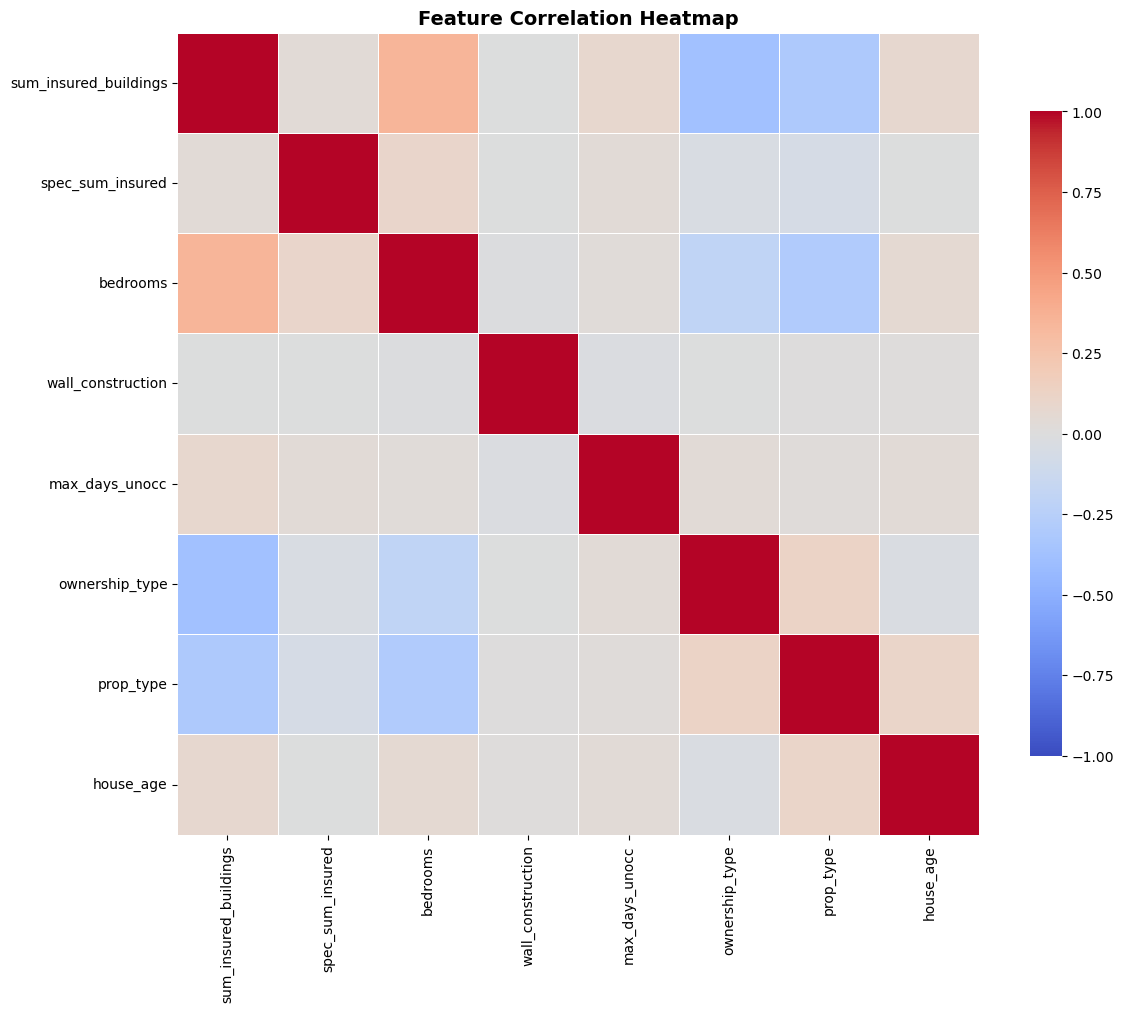

Heatmap plotted.


In [37]:
matrix = calculate_correlation_matrix(df=dataset_encoded, numeric_cols=potential_num_vars)
plot_correlation_heatmap(matrix)

In [38]:
high_corr = find_high_correlations(corr_matrix=matrix, threshold=0.8)
display(high_corr)


No feature pairs found with |correlation| > 0.8


Feature_1,Feature_2,Correlation,Abs_Correlation
str,str,f64,f64


There are a set of 4 variables that are highly correlated with each other. Looking at them and the data dictionary I have decided to create a combied variable of ncd and total sum insured. 
This allows us to drop all 3 of the correlated variables due to the creation of the synthetic variable avg insured by ncd years 
With all the highly correlated numeric variables now managed time to move on to the model. 

Another thing to talk about is that regularising (mean center ect.) of the Sum insured cols would be a way of making sure the combined values and ratios aren't blown out of the water by the value of the building insurance

In [39]:
final_var_list = potential_num_vars + potential_cat_vars + ['lapsed_flag']

In [40]:
len(final_var_list) - 1 # minus target

40

## Save Encoded Output

In [41]:
dataset_encoded = dataset_encoded.select(final_var_list)
data_path = target_dir/"starter_model_dataset.parquet"
dataset_encoded.write_parquet(data_path)